In [8]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import pytz
import random

import scoping.models as sm
import igraph
#import mpld3

from adjustText import adjust_text

In [2]:
# set seed
random.seed(123)

In [3]:
# create project and save tweets to project for easier callup 
# p, created = sm.Project.objects.get_or_create(title='Coal Commission')
# p.pk

196

In [6]:
terms =  [
    '#Kohlekommission',
    '#Kohleausstieg',
    '#Hambibleibt'
]

In [6]:
# Adding tweets to project
for t in terms:
    s, created = tm.TwitterSearch.objects.get_or_create(string=t)
    s.project = p
    s.save()
    print(f"\n{s.string}: {s.status_set.count()}")
    if s.status_set.count() > 1:
        ms = s.status_set.order_by('-retweets_count').first()
        print(f"most retweeted: {ms.retweets_count}")
        print(f"{ms.author} - {ms.created_at}")
        print(ms.text)


#Kohlekommission: 13956
most retweeted: 409
campact - @campact - 2018-08-24 09:42:14+00:00
Wenn es nach @RWE_AG geht, soll einer der ältesten Wälder Deutschlands für eine Technologie weichen, deren Ende beschlossene Sache ist. Wir appellieren an die #Kohlekommission und die #Bundesregierung: Retten Sie den #HambacherForst! Hier unterzeichnen: https://t.co/lsjUFgc1NX https://t.co/nR6vJI826G

#Kohleausstieg: 56275
most retweeted: 538
Ralph Goldmann - @RalphGoldmann - 2019-06-21 12:07:32+00:00
Das muss man hochkant sehen. 😳 #FridaysForFurture #aachen #AC2106 #kohleausstieg @ZDFheute pic.twitter.com/5DpBpDbjKm

#Hambibleibt: 121799
most retweeted: 1180
Raphael Thelen - @RaphaelThelen - 2018-10-06 13:14:12+00:00
Die neuen besorgten Bürger: - 50.000 Menschen bei #Hambibleibt - 30.000 Menschen bei #wellcomeunited in Hamburg - 100.000 bei der #Seebrücke in ganz Deutschland - 65.000 bei #wirsindmehr in Chemnitz - 40.000 bei #nopag und #ausgehetzt in München Ist das der Linksruck?


---

### Loading project, descriptives

In [3]:
p = sm.Project.objects.get(pk=196)

In [15]:
end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')
end_date.tzinfo

datetime.timezone.utc

In [18]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project=p)

ttweets = set(tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__lte=end_date
).values_list('id',flat=True))

print(len(ttweets))

154576


In [19]:
# Take a sample of the texts
texts = tm.Status.objects.filter(
    id__in=random.sample(ttweets, 20000)
).values_list('text',flat=True)


# Stem and vectorize the texts (need to remove @s?)
from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf = vectorizer.fit_transform(texts)

In [20]:
# Run tm on tweets to get general idea 
K = 10

model = NMF(
    n_components=K, random_state=1,
    alpha=0.01, l1_ratio=.91,
    init='nndsvd'
).fit(tfidf)

dtm = model.transform(tfidf)

In [21]:
tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


##############################################
### Topic 0
hambibleibt mensch hambacherwald wald schon mal mehr heut polizei dank


David @drovics hat anlässlich des tragischen Tods einen Song für @HambiBleibt, @AktionUnterholz, @enough14 und alle andere geschrieben, die die Proteste vor Ort unterstützen 
#HambiBleibt #AktionUnterholz #hambibleibt #HambacherForst https://t.co/5FIfdSwjTd

#HambacherForst #Hambibleibt | Video @JeBri74073477 : #HAMBIBLEIBT #IRRWEGE TAG X 2018  BITTE TEILEN  https://youtu.be/DowGhjjgsGY  @HambiBleibt

Ab jetzt in der WAA <3 #hambibleibt Poster. Im Winter & Sommer Look.  Vielen Dank dafür @Ti_Wag #HambacherForst #waableibt #hambibleibt #FridaysForFuture @HambiBleibt @HambiChaos pic.twitter.com/chzwmoiQSH

19:44 @HambiBleibt tweeted: #HambacherForst #Hambibleibt - #Lorien: Cops guarding at Punkpod. #HambacherForest Images by @HambiBleibt https://t.co/N9OQqNRH6e

Welche Bezeichnung meinst Du jetzt: etwa #hambibleibt oder #hambi?  Also wenn Du #Hambibleibt me

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
    
print_top_words(model, tfidf_feature_names, 10)


Topic #0:
hambibleibt mensch hambacherwald wald schon mal mehr heut polizei dank

Topic #1:
kohleausstieg klimaschutz energiew kohl deutschland klimawandel mehr cdu schnell schon

Topic #2:
the for coal with are peopl from germany that hav

Topic #3:
hambacherforst hambibleibt hambi hambacherwald endegeland polizei raumung hambacherfor hambimussweg noblackout

Topic #4:
rwe braunkohl nrw rweag arminlaschet wald amp rod polit reul

Topic #5:
hambi fridaysforfutur climatejustic extinctionrebellion climatechang gretathunberg endcoal climatestr volksbegehrenartenvielfalt climateemergency

Topic #6:
kohlekommission kohl amp braunkohl heut klimaschutz energiew ergebnis klima rweag

Topic #7:
endcoal geht via campact appell unterzeichn groko klimaziel gar aufgeb

Topic #8:
hambach forst wald hambibleibt aach raumung polizei rodung nachricht zeitung

Topic #9:
endegela end geland endcoal endegeland aktionunterholz fridaysforfutur manheimlebt hambigehtweit fing



In [23]:
nmf_embedding = model.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

---

In [24]:
# tsne test 
from sklearn.manifold import TSNE
tsne = TSNE(random_state=123)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)

In [25]:
tsne_embedding[:10]

,x,y,hue
0,-71.275719,-3.562341,1
1,-49.597870,17.003637,1
2,-52.598705,-3.691762,1
3,-83.485916,-4.183634,1
4,-83.485916,-4.183636,1
5,-70.383568,-28.090685,1
6,-55.970299,18.530602,1
7,-82.518852,-7.471344,1
8,-72.028099,-30.441122,1
9,-71.824394,-3.741672,1


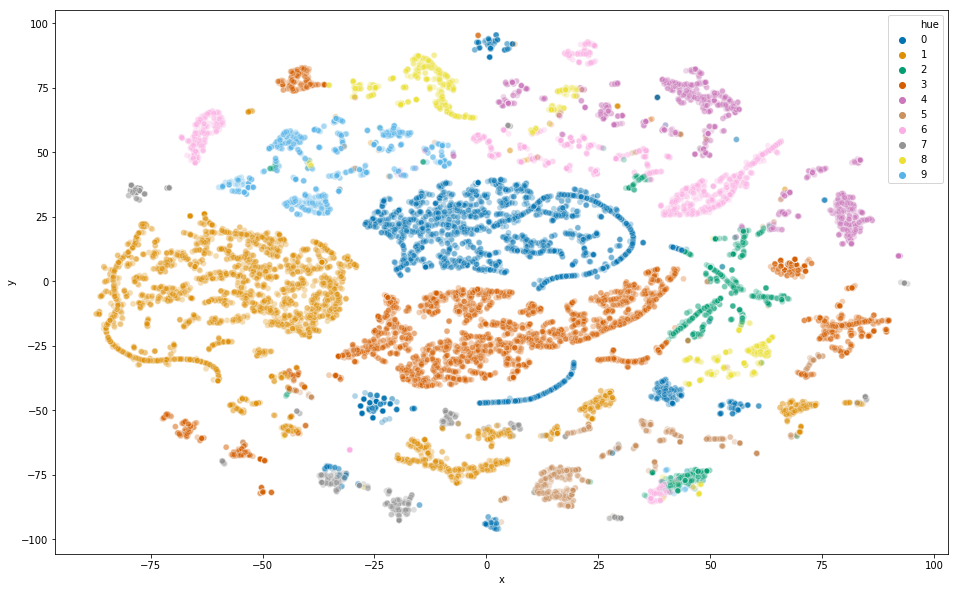

In [30]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_embedding['x'], y=tsne_embedding['y'],
    hue=tsne_embedding['hue'],
    palette=sns.color_palette("colorblind", 10),
    legend="full",
    alpha=0.3
)
plt.savefig("plots/tsne.png", dpi=200)
plt.show()

---

### Sentiment Analysis